In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader

In [2]:
from matplotlib import rcParams

# Restore old behavior of rounding default axis ranges
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0

In [3]:
dta_pl = pd.read_stata('data/data_PL.dta')
dta_pl.head()

,WIB3M,HICP,GDP,t,REER
0,22.15,17.233333,6.2,1,7.863447
1,22.50,15.066667,5.5,2,6.201926
2,25.01,14.666667,5.5,3,6.886372
3,24.99,13.166667,10.8,4,3.212281
4,24.90,13.900000,6.3,5,5.660251


In [4]:
yy = (2000+(dta_pl['t']-1)//4).astype(str)
qq = (1+(dta_pl['t']-1)%4).astype(str)
date = yy+'Q'+qq

from statsmodels.tsa.base.datetools import dates_from_str
date = dates_from_str(date)

dta_pl.index = date

dta_pl = dta_pl.resample('QS').mean()

dta_pl.tail()

,WIB3M,HICP,GDP,t,REER
2016-04-01,2.95,0.500000,1.3,66,0.284523
2016-07-01,2.70,0.900000,2.0,67,-3.306167
2016-10-01,2.66,0.600000,2.5,68,-2.217042
2017-01-01,2.71,0.633333,3.5,69,-0.620638
2017-04-01,2.71,0.300000,3.3,70,NaN


In [5]:
model_pl = sm.tsa.VAR(dta_pl[['GDP','HICP','WIB3M']])

In [6]:
print(model_pl.select_order(8))
model_pl.select_order(8).summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 5, BIC -> 1, FPE -> 5, HQIC -> 5>


,AIC,BIC,FPE,HQIC
0,5.209,5.312,182.9,5.249
1,-1.657,-1.245*,0.1909,-1.495
2,-1.643,-0.9222,0.1940,-1.360
3,-1.519,-0.4898,0.2208,-1.115
4,-1.815,-0.4774,0.1659,-1.290
5,-2.221*,-0.5740,0.1125*,-1.574*
6,-2.171,-0.2157,0.1212,-1.404
7,-2.104,0.1602,0.1343,-1.215
8,-2.196,0.3769,0.1287,-1.186


In [7]:
results_pl = model_pl.fit(6)
# results_pl.summary()

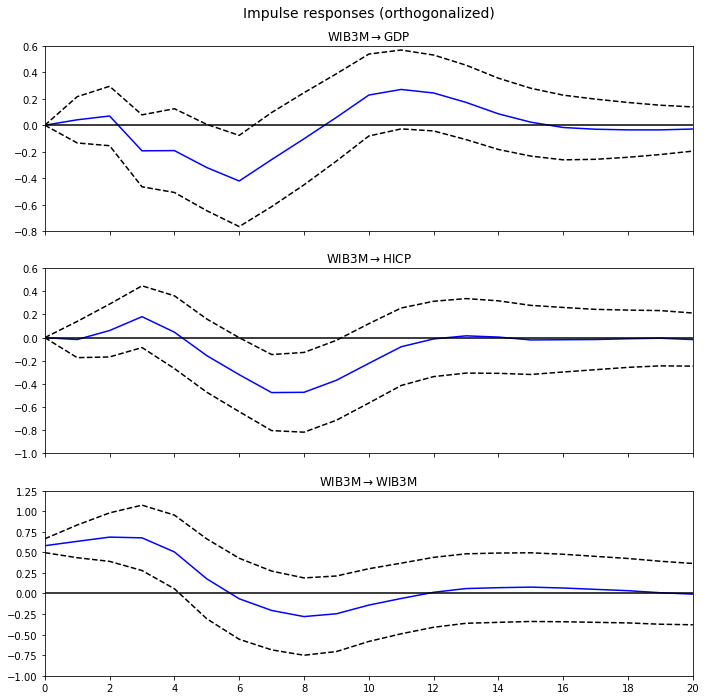

In [8]:
irf_pl = results_pl.irf(20)
irf_pl.plot(orth=True, impulse='WIB3M', signif=0.1)
plt.xticks(np.arange(0, 22, 2))
plt.show()

In [9]:
fred = DataReader(['GDPC1','GDPDEF','FEDFUNDS','M2SL'], 'fred', start='1945', end='2030')

In [10]:
temp = fred.resample('QS').mean()

iacoviello = 100*np.log(temp).diff(4)
iacoviello['FEDFUNDS'] = temp['FEDFUNDS']
iacoviello = iacoviello.dropna()

iacoviello.columns = ['Y','P','R','M']
iacoviello.head()

,Y,P,R,M
DATE,,,,
1960-01-01,4.809567,1.330801,3.933333,3.705812
1960-04-01,2.037380,1.425173,3.696667,3.023212
1960-07-01,2.454286,1.389750,2.936667,3.441176
1960-10-01,0.877912,1.294692,2.296667,4.539756
1961-01-01,-0.671745,1.104586,2.003333,5.725141


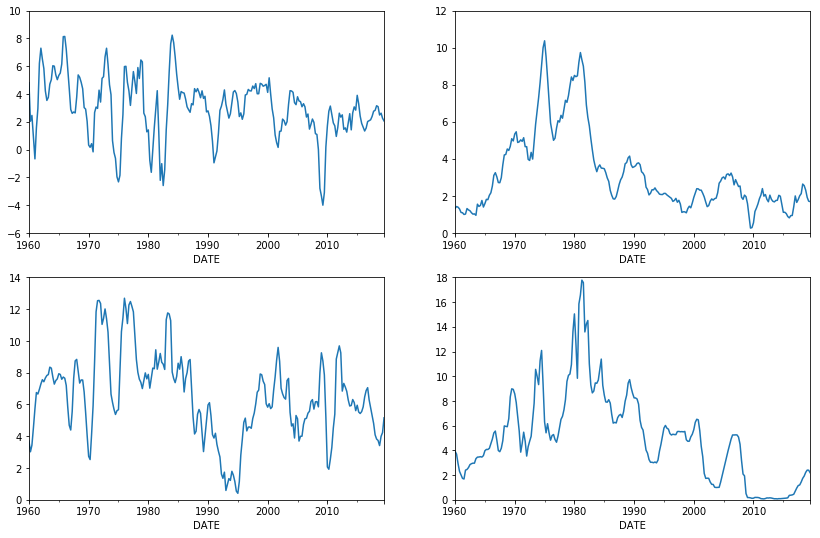

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))

iacoviello['Y'].to_period('D').plot(ax=ax1)
iacoviello['P'].to_period('D').plot(ax=ax2)
iacoviello['M'].to_period('D').plot(ax=ax3)
iacoviello['R'].to_period('D').plot(ax=ax4)

plt.show()

In [12]:
model = sm.tsa.VAR(iacoviello[['Y','P','R','M']])
print(model.select_order(8))
model.select_order(8).summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 6, BIC -> 2, FPE -> 6, HQIC -> 6>


,AIC,BIC,FPE,HQIC
0,6.589,6.649,727.0,6.613
1,-2.715,-2.417,0.06622,-2.595
2,-3.457,-2.921*,0.03152,-3.241
3,-3.513,-2.739,0.02981,-3.201
4,-3.510,-2.497,0.02993,-3.101
5,-3.830,-2.579,0.02174,-3.326
6,-4.008*,-2.518,0.01823*,-3.407*
7,-4.005,-2.276,0.01833,-3.307
8,-4.006,-2.039,0.01834,-3.213


In [13]:
results = model.fit(6)

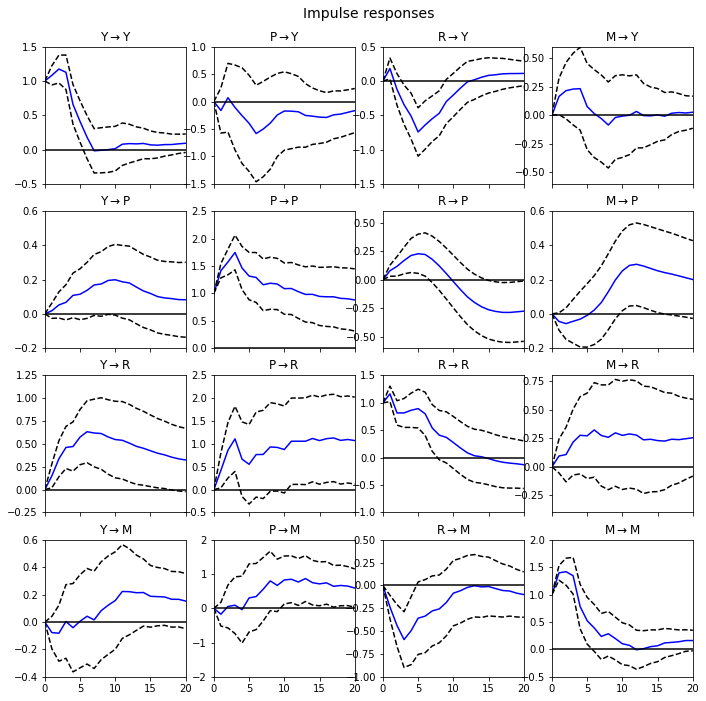

In [14]:
results.irf(20).plot()
plt.show()

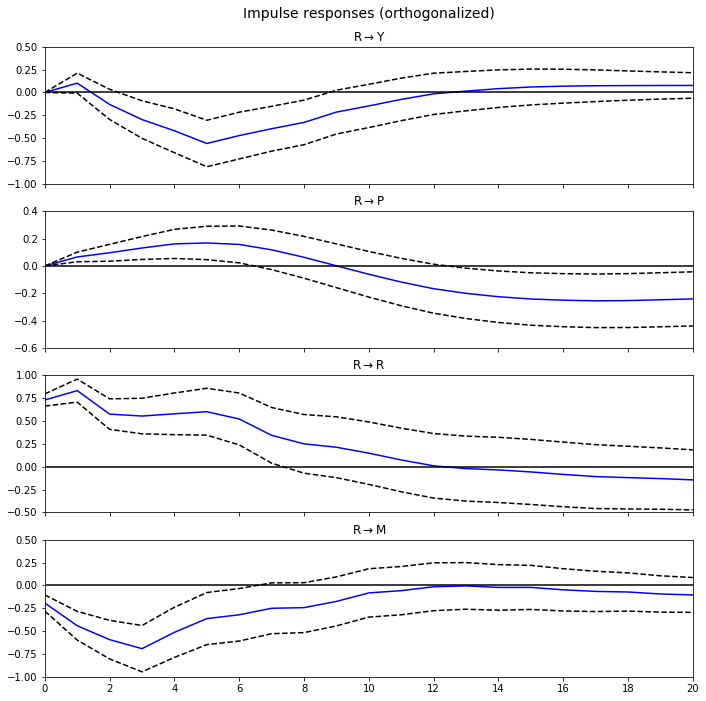

In [15]:
results.irf(20).plot(orth=True, impulse='R', signif=0.05)
# plt.savefig('Simple_VAR.pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)
plt.xticks(np.arange(0, 22, 2))
plt.show()

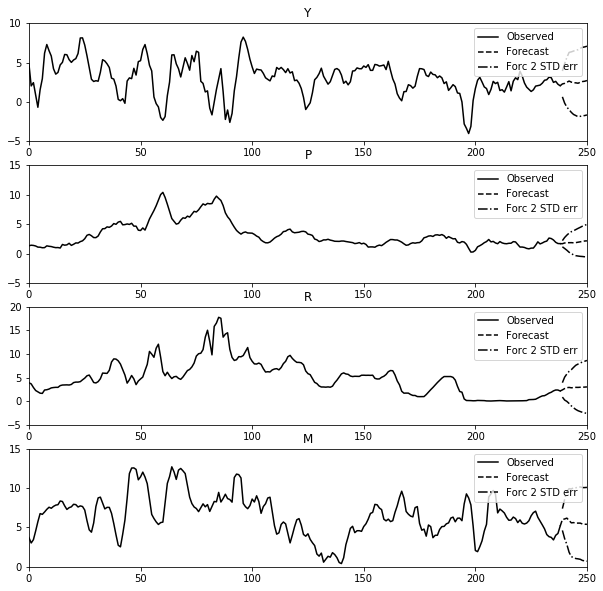

In [16]:
results.plot_forecast(12)
plt.show()

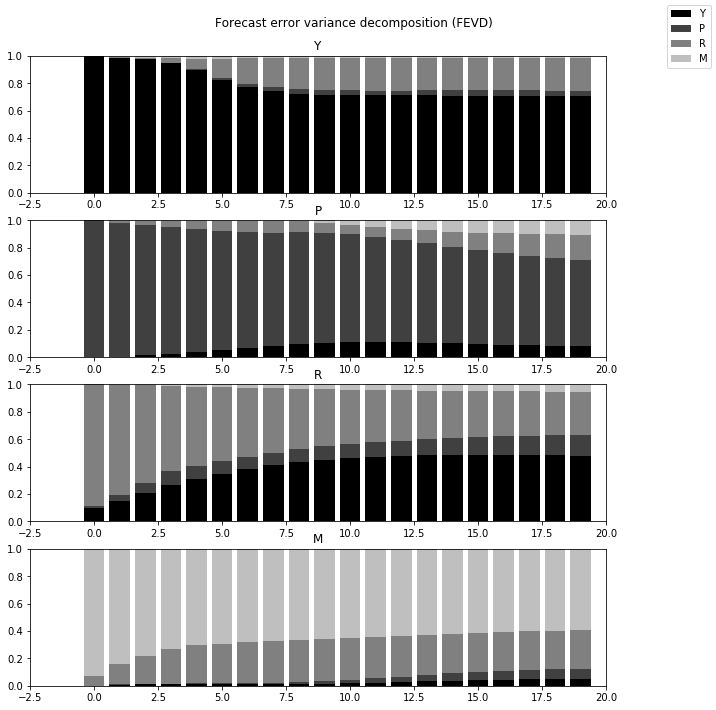

In [17]:
results.fevd(20).plot()
plt.show()

In [18]:
iacoviello.tail()

,Y,P,R,M
DATE,,,,
2018-07-01,3.085445,2.554770,1.923333,3.736035
2018-10-01,2.485353,2.312247,2.220000,3.413053
2019-01-01,2.617679,1.918294,2.403333,3.997444
2019-04-01,2.252754,1.714438,2.396667,4.230893
2019-07-01,2.057091,1.691003,2.190000,5.162450


In [19]:
f = results.forecast(iacoviello.to_numpy(), 10)

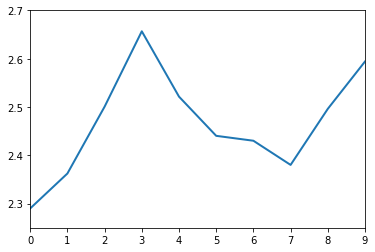

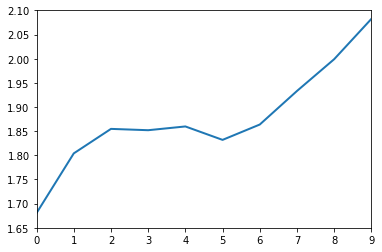

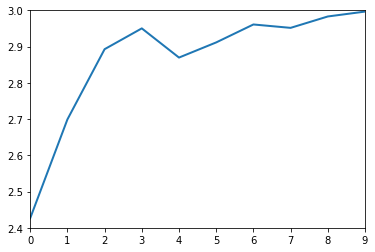

In [20]:
plt.plot(f.transpose()[0], lw=2)
plt.xticks(range(10))
plt.show()

plt.plot(f.transpose()[1], lw=2)
plt.xticks(range(10))
plt.show()

plt.plot(f.transpose()[2], lw=2)
plt.xticks(range(10))
plt.show()